In [1]:
import pandas as pd
import itertools
from sklearn.metrics import confusion_matrix
from tqdm import tqdm
tqdm.pandas()

# Summary

The Deepface framework we used in our study also uses the OpenCv library during the face detection phase. In the process of recognition and vector expression of the face, it uses deep learning-based facial recognition models (Serengil &Özpinar, 2020). Face recognition models are regular convolutional neural networks models. They represent face photos as vectors. We find the distance between these two vectors to compare two faces. Finally, we classify two faces as same person whose distance is less than a threshold value(Serengil, 2020b).

Using the Google Facenet facial recognition model and the euclidean_l2 metric, we will calculate the threshold values in the Mix Data set.

For the original notebook, see:
https://github.com/serengil/deepface/blob/master/tests/Fine-Tuning-Threshold.ipynb

# Mix Data set

In [2]:
idendities = {
    "Laura_Harrier": ["img1.jpg", "img2.jpg", "img3.jpg", "img4.jpg"],
    "Zendaya": ["img5.jpg", "img6.jpg", "img7.jpg", "img8.jpg"],
    "Tom_Holland": ["img9.jpg", "img10.jpg", "img11.jpg", "img12.jpg"],
    "Andrew_Garfield": ["img13.jpg", "img14.jpg", "img15.jpg", "img16.jpg"],
    "Jodie_Comer":["img17.jpg", "img18.jpg", "img19.jpg", "img20.jpg"],
    "Emma_Stone": ["img21.jpg", "img22.jpg", "img23.jpg", "img24.jpg"],
    "Will_Smith": ["img25.jpg", "img26.jpg", "img27.jpg", "img28.jpg"],
    "Lance Reddick": ["img29.jpg", "img30.jpg", "img31.jpg", "img32.jpg"],
    "Lee_Jung_jae": ["img33.jpg", "img34.jpg", "img35.jpg", "img36.jpg"],
    "Choi_Min_sik": ["img37.jpg", "img38.jpg", "img39.jpg", "img40.jpg"],
    "HoYeon Jung": ["img41.jpg", "img42.jpg", "img43.jpg", "img44.jpg"],
    "Sandra_Oh": ["img45.jpg", "img46.jpg", "img47.jpg", "img48.jpg"]
}

# Positive samples
Find different photos of same people

In [3]:
positives = []

for key, values in idendities.items():
    
    #print(key)
    for i in range(0, len(values)-1):
        for j in range(i+1, len(values)):
            #print(values[i], " and ", values[j])
            positive = []
            positive.append(values[i])
            positive.append(values[j])
            positives.append(positive)

In [4]:
positives = pd.DataFrame(positives, columns = ["file_x", "file_y"])
positives["decision"] = "Yes"

# Negative samples
Compare photos of different people

In [5]:
samples_list = list(idendities.values())

In [6]:
negatives = []

for i in range(0, len(idendities) - 1):
    for j in range(i+1, len(idendities)):
        #print(samples_list[i], " vs ",samples_list[j]) 
        cross_product = itertools.product(samples_list[i], samples_list[j])
        cross_product = list(cross_product)
        #print(cross_product)
        
        for cross_sample in cross_product:
            #print(cross_sample[0], " vs ", cross_sample[1])
            negative = []
            negative.append(cross_sample[0])
            negative.append(cross_sample[1])
            negatives.append(negative)
        

In [7]:
negatives = pd.DataFrame(negatives, columns = ["file_x", "file_y"])
negatives["decision"] = "No"

# Merge Positives and Negative Samples

In [8]:
df = pd.concat([positives, negatives]).reset_index(drop = True)

In [9]:
df.shape

(1128, 3)

In [10]:
df.decision.value_counts()

No     1056
Yes      72
Name: decision, dtype: int64

In [11]:
df.file_x = "dataset/"+df.file_x
df.file_y = "dataset/"+df.file_y

# DeepFace

In [12]:
from deepface import DeepFace

In [13]:
instances = df[["file_x", "file_y"]].values.tolist()

In [14]:
model_name = "Facenet"
distance_metric = "euclidean_l2"

In [15]:
resp_obj = DeepFace.verify(instances, model_name = model_name, distance_metric = distance_metric)

Verification: 100%|██████████████████████████████████████████████████████████████| 1128/1128 [7:44:23<00:00, 24.70s/it]


In [16]:
distances = []
for i in range(0, len(instances)):
    distance = round(resp_obj["pair_%s" % (i+1)]["distance"], 4)
    distances.append(distance)

In [17]:
df["distance"] = distances

# Analyzing Distances

In [18]:
tp_mean = round(df[df.decision == "Yes"].mean().values[0], 4)
tp_std = round(df[df.decision == "Yes"].std().values[0], 4)
fp_mean = round(df[df.decision == "No"].mean().values[0], 4)
fp_std = round(df[df.decision == "No"].std().values[0], 4)

In [19]:
print("Mean of true positives: ", tp_mean)
print("Std of true positives: ", tp_std)
print("Mean of false positives: ", fp_mean)
print("Std of false positives: ", fp_std)

Mean of true positives:  0.6349
Std of true positives:  0.1016
Mean of false positives:  1.3721
Std of false positives:  0.0943


# Distribution

<AxesSubplot:ylabel='Density'>

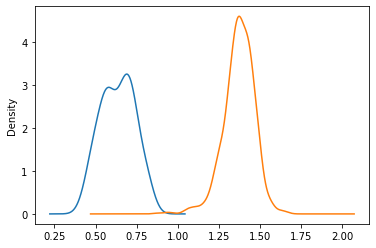

In [20]:
df[df.decision == "Yes"].distance.plot.kde()
df[df.decision == "No"].distance.plot.kde()

# Sigma

In [21]:
sigma = 3
#2 sigma corresponds 95.45% confidence, and 3 sigma corresponds 99.73% confidence

threshold = round(tp_mean + sigma * tp_std, 4)
#hreshold = 0.680#comes from c4.5 algorithm
print("threshold: ", threshold)

threshold:  0.9397


In [22]:
df[df.decision == 'Yes'].distance.max()

0.8381

In [23]:
df[df.decision == 'No'].distance.min()

0.8703

# Evaluation

In [24]:
df["prediction"] = "No"

In [25]:
idx = df[df.distance <= threshold].index
df.loc[idx, 'prediction'] = 'Yes'

In [26]:
df.head(5)

,file_x,file_y,decision,distance,prediction
0,dataset/img1.jpg,dataset/img2.jpg,Yes,0.5013,Yes
1,dataset/img1.jpg,dataset/img3.jpg,Yes,0.4271,Yes
2,dataset/img1.jpg,dataset/img4.jpg,Yes,0.4808,Yes
3,dataset/img2.jpg,dataset/img3.jpg,Yes,0.5103,Yes
4,dataset/img2.jpg,dataset/img4.jpg,Yes,0.4825,Yes


In [27]:
cm = confusion_matrix(df.decision.values, df.prediction.values)

In [28]:
cm

array([[1053,    3],
       [   0,   72]], dtype=int64)

In [29]:
tn, fp, fn, tp = cm.ravel()

In [30]:
tn, fp, fn, tp

(1053, 3, 0, 72)

In [31]:
recall = tp / (tp + fn)
precision = tp / (tp + fp)
accuracy = (tp + tn)/(tn + fp +  fn + tp)
f1 = 2 * (precision * recall) / (precision + recall)

In [32]:
print("Precision: ", 100*precision,"%")
print("Recall: ", 100*recall,"%")
print("F1 score ",100*f1, "%")
print("Accuracy: ", 100*accuracy,"%")

Precision:  96.0 %
Recall:  100.0 %
F1 score  97.95918367346938 %
Accuracy:  99.7340425531915 %


In [33]:
df.to_csv("threshold_pivot_mix_Facenet.csv", index = False)

## Test results

### Threshold = 0.68 

Precision:  100.0 %
Recall:  63.88 %
F1 score  77.96 %
Accuracy:  97.69 %

### Threshold =  0.7369 (1 sigma)

Precision:  100.0 %
Recall:  86.11 %
F1 score  92.53 %
Accuracy:  99.11 % 

### Threshold =  0.8384 (2 sigma)
     
Precision:  100.0 %
Recall:  100.0 %
F1 score  100.0 %
Accuracy:  100.0 % 

### Threshold =  0.9399 (3 sigma)

Precision:  96.0 %
Recall:  100.0 %
F1 score  97.95 %
Accuracy:  99.73 %

### Threshold =  1.16 

Precision:  72.72 %
Recall:  100.0 %
F1 score  84.21 %
Accuracy:  97.60 %
